# esm4.2 testing
In order to track esm4.2 progress over time, we will setup methods to collect data day by day, and then produce time dependent plots to show progress

Recorded data will be average per job format, with error. Sort by date.

In [1]:
# import  epmt query 
print('importing epmt_query')
import epmt_query as eq
# import matplot for better plotting functions
import sys
sys.path.insert(0,'/home/Avery.Kiihne/pip_experiment')
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
# import pandas. optional but helpful 'display.max_columns' arg shows all DataFrame columns when printing
print('importing pandas')
import pandas as pd
import pickle   #to load in metrics history
pd.set_option('display.max_columns', None)

importing epmt_query
importing pandas


In [5]:
#We gather initial estimates and get a list of IDs for the specific date
start_date = datetime.datetime(2024, 6, 2, 23, 59)    #day that ends the week
older_date = start_date + datetime.timedelta(days =-1) 
date = (start_date.strftime("%m")+'-'+start_date.strftime("%d")+'-'+start_date.strftime("%y")) #date in an easy to read format
#use orm and trigger_post_process=False to get data quickly
start = time.time()
older_orm = eq.get_jobs(after=older_date, fmt = 'orm',trigger_post_process=False)
start_orm = eq.get_jobs(after=start_date, fmt = 'orm',trigger_post_process=False)
job_num = older_orm.count() - start_orm.count()    #clip off the jobs that happened between current time and the end of the week being reported on
all_jobs=eq.get_jobs(limit =int(job_num), offset = start_orm.count(), fmt='orm',trigger_post_process=False)
#sort data by esm4.2 tag in exp_name
ESM_exp_jobids=[]
ESM_exp_names=[]
total_jobs=all_jobs.count()
job_num=0
for job in all_jobs:
    job_num=job_num+1
    exp_name=job.tags.get('exp_name')
    if job_num%1000 == 0:
        print(f'job_num/total_jobs={job_num}/{total_jobs}')
    if exp_name is None:
        continue
    if ('ESM4p2' in exp_name) or ('esm4p2' in exp_name.lower()):
        ESM_exp_jobids.append(job.jobid)
        if exp_name in ESM_exp_names:
            continue
        else:
            ESM_exp_names.append(exp_name)
print('number of ESM4.2 jobs: ', len(ESM_exp_jobids))

job_num/total_jobs=1000/4367
job_num/total_jobs=2000/4367
job_num/total_jobs=3000/4367
job_num/total_jobs=4000/4367
number of ESM4.2 jobs:  258


In [3]:
#get jobs in dict format, if there is more than 10
if len(ESM_exp_jobids) >= 10:
    #setup dictionaries
    metrics_list = {'rssmax','write_bytes','duration','cpu_time','read_bytes', 'num_procs', 'time_waiting'}
    metrics_dict = {}
    for metric in metrics_list:
        metrics_dict[metric] = []
    metrics_dict['flux'] = []
    esm4p2_jobs = eq.get_jobs(jobs = ESM_exp_jobids, fmt = 'dict', trigger_post_process=False)
    for job in esm4p2_jobs:
        if job.get('rssmax') == None:
            job = eq.get_jobs(jobs = job['jobid'], fmt = 'dict')[0]
        
        for metric in metrics_list:
            metrics_dict[metric].append(job[metric])
        metrics_dict['flux'].append((job['read_bytes']+job['write_bytes'])/job['cpu_time'])

# record keeping
We transform data into averages and append that dictionary onto a file that can be called even once the DB is erased.

In [4]:
#process data by getting average, and add errors
for metric in list(metrics_dict.keys()):
    metrics_dict[metric+'_error'] = np.std(metrics_dict[metric])/(len(metrics_dict[metric]))**.5
    metrics_dict[metric] = sum(metrics_dict[metric])/len(metrics_dict[metric])
metrics_dict['date'] = date
metrics_dict['num_jobs'] = len(ESM_exp_jobids)


In [5]:
#record metrics based on date (to avoid repitition)
filename = 'esm4.2_history_'+'DO_NOT_DELETE.pkl'
# Read dictionary pkl file
with open(filename, 'rb') as fp:
    metrics_history = pickle.load(fp)
#record new dates
if date not in metrics_history['date']:
    for key in list(metrics_history.keys()):
        metrics_history[key].append(metrics_dict[key])
# save dictionary to weekly_metric_storage_DO_NOT_DELETE.pkl file
with open(filename, 'wb') as fp:
    pickle.dump(metrics_history, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [6]:
#Be careful, as this creates a blank file for the dictionary of metrics. If used foolishly, can delete long term data. Only use if creating new folder or want to reset all data
#creat dictionarymetrics_dict['canopy']
'''filename = 'esm4.2_history_'+'DO_NOT_DELETE.pkl'
metrics_list = {'rssmax','write_bytes','duration','cpu_time','read_bytes', 'num_procs', 'time_waiting'}
metrics_dict = {}
for metric in metrics_list:
    metrics_dict[metric] = []
    metrics_dict[metric+'_error'] = []
metrics_dict['flux'] = []
metrics_dict['flux_error'] = []
metrics_dict['num_jobs'] = []
metrics_dict['date'] = []

# save dictionary to weekly_metric_storage_DO_NOT_DELETE.pkl file
with open(filename, 'wb') as fp:
    pickle.dump(metrics_dict, fp)
    print('dictionary saved successfully to file')
    print(metrics_dict)'''

"filename = 'esm4.2_history_'+'DO_NOT_DELETE.pkl'\nmetrics_list = {'rssmax','write_bytes','duration','cpu_time','read_bytes', 'num_procs', 'time_waiting'}\nmetrics_dict = {}\nfor metric in metrics_list:\n    metrics_dict[metric] = []\n    metrics_dict[metric+'_error'] = []\nmetrics_dict['flux'] = []\nmetrics_dict['flux_error'] = []\nmetrics_dict['num_jobs'] = []\nmetrics_dict['date'] = []\n\n# save dictionary to weekly_metric_storage_DO_NOT_DELETE.pkl file\nwith open(filename, 'wb') as fp:\n    pickle.dump(metrics_dict, fp)\n    print('dictionary saved successfully to file')\n    print(metrics_dict)"

# Progress plots
Plots to display porgress over time of varous statistics

Text(0.5, 1.0, '# of ESM4.2 Jobs Per Day')

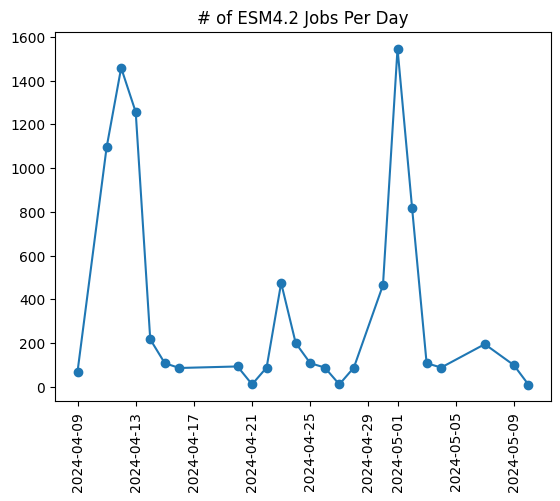

In [8]:
#first create the plot of number of esm4.2 jobs
plt.style.use('default')
date_time =metrics_history['date']
date_time = pd.to_datetime(date_time)
df = pd.DataFrame()
df['value'] = metrics_history['num_jobs']
df = df.set_index(date_time)
df = df.sort_index(ascending=True)
plt.plot(df.index,df['value'])
plt.scatter(df.index,df['value'])
plt.xticks(rotation=90)
plt.title('# of ESM4.2 Jobs Per Day')

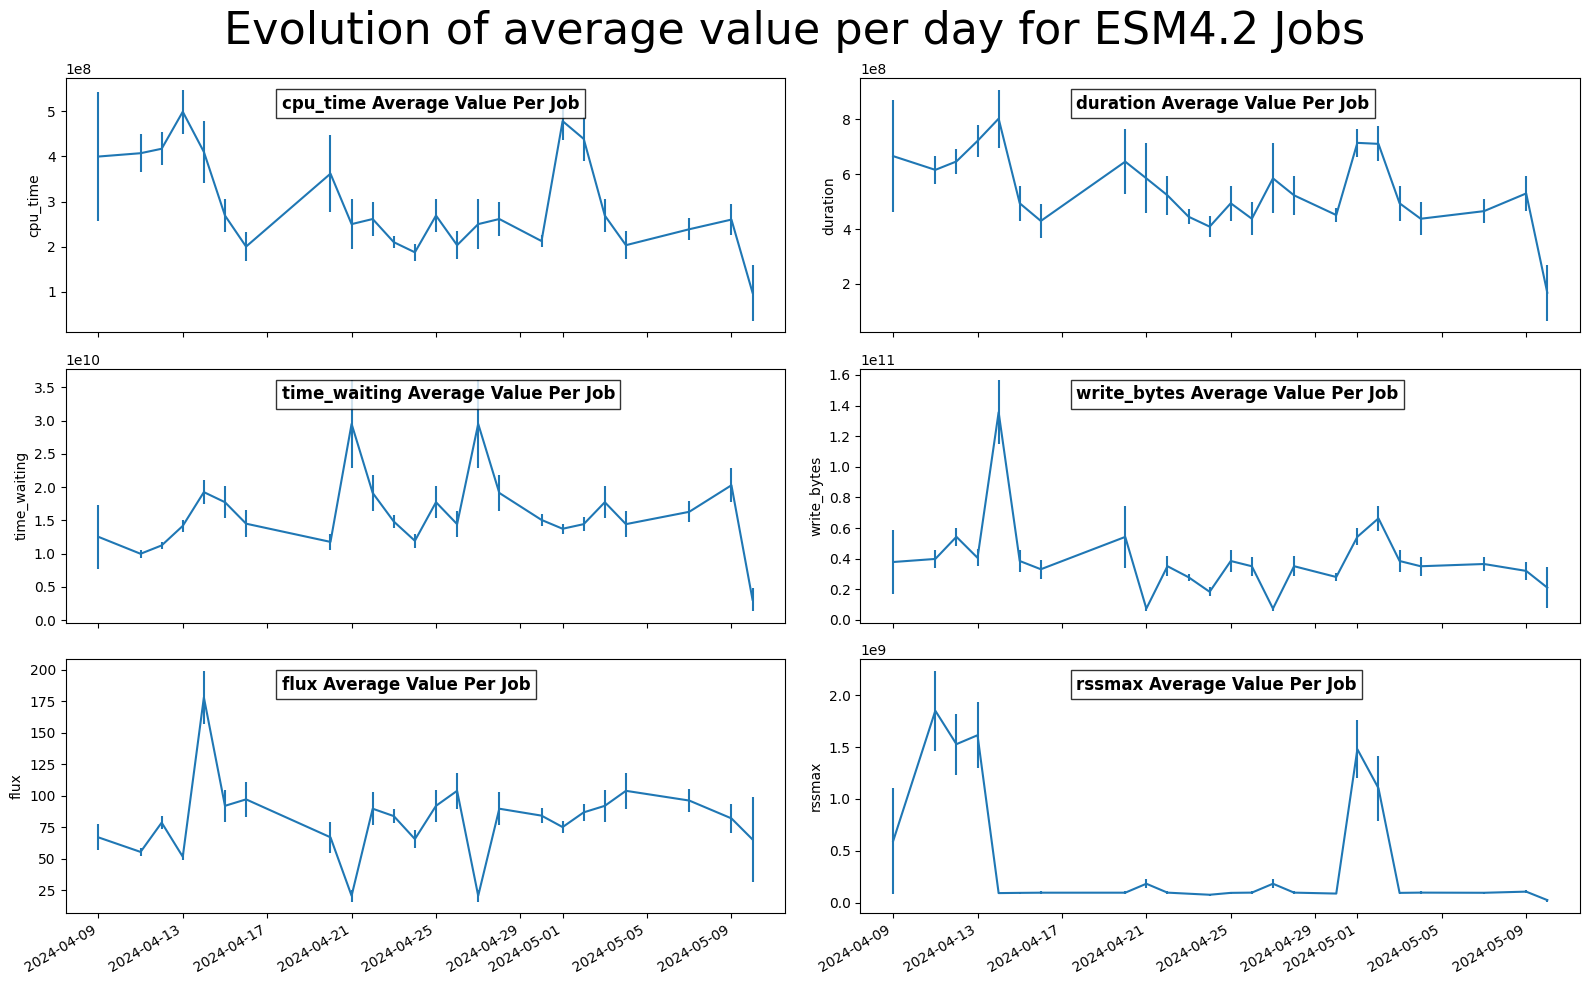

In [9]:
#create a multipanel plot with a shared x-axis of dates
#setup
plt.style.use('default')
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(16,10), sharex = True)
ax =ax.ravel() 
#now cycle through chose variables for plotting information
metrics_list = ['cpu_time', 'duration','time_waiting','write_bytes','flux','rssmax']
for aa in range(6):
    date_time =metrics_history['date']
    date_time = pd.to_datetime(date_time)
    df = pd.DataFrame()
    df['value'] = metrics_history[metrics_list[aa]]
    df['value_error'] = metrics_history[metrics_list[aa]+'_error']
    df = df.set_index(date_time)
    df = df.sort_index(ascending=True)
    ax[aa].errorbar(df.index,df['value'], yerr = df['value_error'])
    ax[aa].set_ylabel(metrics_list[aa])
    ax[aa].annotate(metrics_list[aa]+' Average Value Per Job', xy=(0.3, 0.9), xycoords="axes fraction",color = 'black', fontsize =12, weight = 'bold',horizontalalignment='left',verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

plt.gcf().autofmt_xdate()
plt.suptitle('Evolution of average value per day for ESM4.2 Jobs', fontsize = 32)
plt.tight_layout()
plt.show()

In [ ]:
metrics_history

In [1]:
import smtplib
